# *Bacillus subtilis* Diauxic Shift

Here we will attempt to reproduce the results from [Rosenthal et al. 2018](https://elifesciences.org/articles/33099). 

The shared environment will contain 50 mM Malate and 22 mM Glucose. We will assume that the environment is 1L in volume - to avoid unit conversions. 

Initial biomass is set to 0.5.

In [22]:
from copy import deepcopy
import cobra
import cobra.flux_analysis
from process_bigraph import Composite
from process_bigraph.composite import ProcessTypes

from cdFBA import register_types
from cdFBA.processes.dfba import DFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, model_from_file, set_concentration, set_kinetics
from cdFBA.utils import get_exchanges, get_substrates, get_reaction_map

from matplotlib import pyplot as plt
from pprint import pprint

import cProfile
import pstats
import io

In [23]:
model_file = 'iYO844'

In [24]:
model_dict = {'B. subtilis': model_file}
exchanges = ['EX_ac_e','EX_actn__R_e', 'EX_mal__L_e', 'EX_glc__D_e']
#'EX_mal__L_e', 'EX_glc__D_e'
volume = 1
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.5)

In [25]:
spec

{'dFBA Results': {'B. subtilis': {'Acetate': 0,
   ' R  Acetoin C4H8O2': 0,
   'L-Malate': 0,
   'D-Glucose': 0,
   'B. subtilis': 0}},
 'shared environment': {'volume': 1,
  'counts': {'D-Glucose': 20,
   'L-Malate': 20,
   'Acetate': 20,
   ' R  Acetoin C4H8O2': 20,
   'B. subtilis': 0.5},
  'concentrations': {'D-Glucose': 20.0,
   'L-Malate': 20.0,
   'Acetate': 20.0,
   ' R  Acetoin C4H8O2': 20.0,
   'B. subtilis': 0.5}},
 'B. subtilis': {'_type': 'process',
  'address': 'local:DFBA',
  'config': {'model_file': 'iYO844',
   'name': 'B. subtilis',
   'kinetics': {'Acetate': (0.5, 2.0),
    ' R  Acetoin C4H8O2': (0.5, 2.0),
    'L-Malate': (0.5, 2.0),
    'D-Glucose': (0.5, 2.0)},
   'reaction_map': {'Acetate': 'EX_ac_e',
    ' R  Acetoin C4H8O2': 'EX_actn__R_e',
    'L-Malate': 'EX_mal__L_e',
    'D-Glucose': 'EX_glc__D_e'},
   'biomass_identifier': 'BIOMASS_BS_10',
   'bounds': {}},
  'inputs': {'shared_environment': ['shared environment'],
   'current_update': ['dFBA Results']},
 

In [26]:
#Set reaction bounds
spec['B. subtilis']['config']['bounds'] = {
            'EX_o2_e': {'lower': -2, 'upper': None},
            'ATPM': {'lower': 1, 'upper': 1}
        }
#Set initial concentrations
concentrations = {
    'Acetate': 0,
    'D-Glucose': 22,
    'L-Malate': 55,
    ' R  Acetoin C4H8O2': 0
}
set_concentration(spec, concentrations)


In [27]:
pprint(spec)

{'B. subtilis': {'_type': 'process',
                 'address': 'local:DFBA',
                 'config': {'biomass_identifier': 'BIOMASS_BS_10',
                            'bounds': {'ATPM': {'lower': 1, 'upper': 1},
                                       'EX_o2_e': {'lower': -2, 'upper': None}},
                            'kinetics': {' R  Acetoin C4H8O2': (0.5, 2.0),
                                         'Acetate': (0.5, 2.0),
                                         'D-Glucose': (0.5, 2.0),
                                         'L-Malate': (0.5, 2.0)},
                            'model_file': 'iYO844',
                            'name': 'B. subtilis',
                            'reaction_map': {' R  Acetoin C4H8O2': 'EX_actn__R_e',
                                             'Acetate': 'EX_ac_e',
                                             'D-Glucose': 'EX_glc__D_e',
                                             'L-Malate': 'EX_mal__L_e'}},
                 'inputs': {'

In [28]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["shared environment"],
            "global_time": ["global_time"]
        }
    }

In [29]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('DFBA', DFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [30]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [31]:
sim.run(100)

/opt/anaconda3/envs/cdFBA/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [32]:
results = sim.gather_results()[('emitter',)]

In [33]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

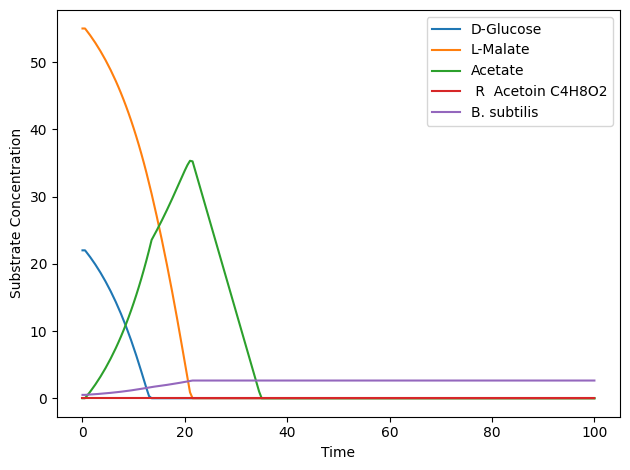

In [34]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in []:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()
#'B. subtilis', 'Acetate', 'R Acetoin'

In [21]:
results

[{'shared_environment': {'concentrations': {'D-Glucose': 22,
    'L-Malate': 55,
    'Acetate': 0,
    ' R  Acetoin C4H8O2': 0,
    'B. subtilis': 0.5},
   'counts': {'D-Glucose': 22,
    'L-Malate': 55,
    'Acetate': 0,
    ' R  Acetoin C4H8O2': 0,
    'B. subtilis': 0.5},
   'volume': 1}},
 {'shared_environment': {'counts': {'D-Glucose': 22,
    'L-Malate': 55,
    'Acetate': 0,
    ' R  Acetoin C4H8O2': 0,
    'B. subtilis': 0.5},
   'concentrations': {'D-Glucose': 22.0,
    'L-Malate': 55.0,
    'Acetate': 0.0,
    ' R  Acetoin C4H8O2': 0.0,
    'B. subtilis': 0.5},
   'volume': 1}},
 {'shared_environment': {'counts': {'D-Glucose': np.float64(21.511111111111113),
    'L-Malate': np.float64(54.5045045045045),
    'Acetate': np.float64(0.47252385999311625),
    ' R  Acetoin C4H8O2': 0,
    'B. subtilis': np.float64(0.5241724118727866)},
   'concentrations': {'D-Glucose': np.float64(21.511111111111113),
    'L-Malate': np.float64(54.5045045045045),
    'Acetate': np.float64(0.4725238